# Machine Learning Project: Passanger Satisfaction
### Bence Szabo

My goal is to predict whether the passengers were satisfied with their travel taking in account as much of the available data as there are while being fully consistent the relationship between human needs and the underlying factors that drive satisfaction and dissatisfaction within the context of air travel, such as minimizing negative experiences (delays, poor service) and maximizing positive ones (comfort, convenience, and value)

In [79]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import kagglehub

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Download latest version
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

df_train = pd.read_csv(f"{path}/train.csv")
df_test = pd.read_csv(f"{path}/test.csv")

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/teejmahal20/airline-passenger-satisfaction/versions/1


In [80]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


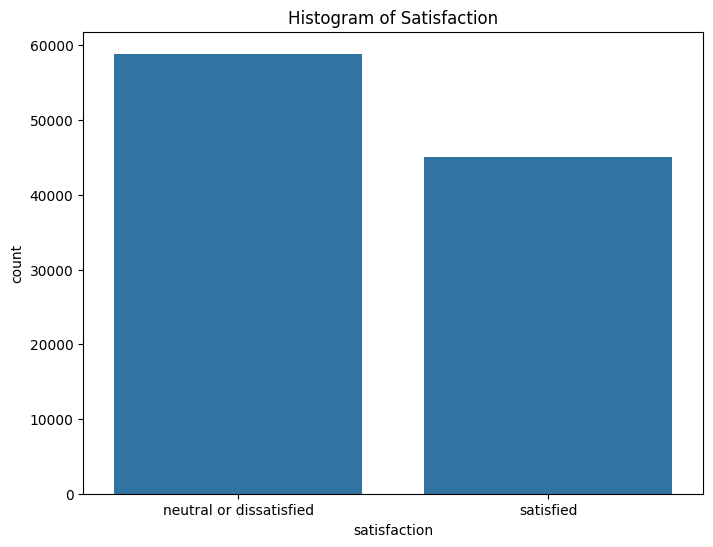

In [81]:
# Histogram of satisfaction
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='satisfaction')
plt.title('Histogram of Satisfaction')
plt.show()

Seems like the passangers are not truly satisfied with their booked flights, therefore this company indeed needs a helping a hand solving this problem!

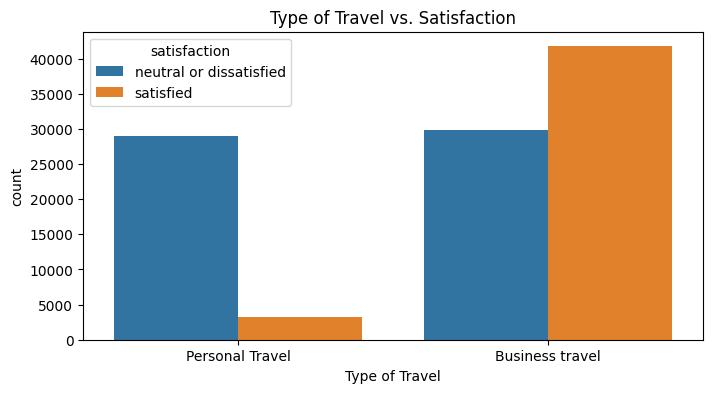

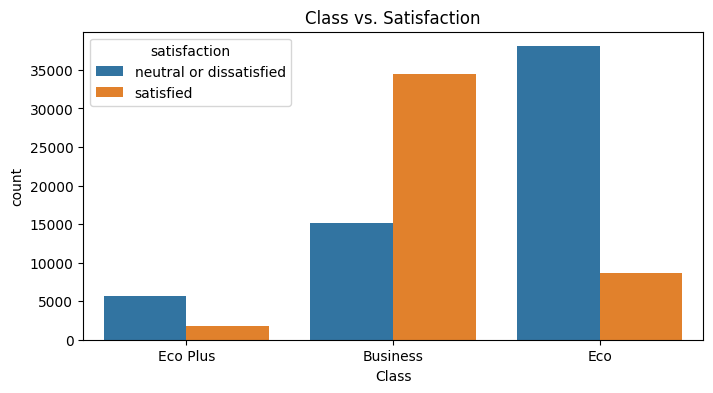

In [82]:
# Travel Details vs. Satisfaction
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='Type of Travel', hue='satisfaction')
plt.title('Type of Travel vs. Satisfaction')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='Class', hue='satisfaction')
plt.title('Class vs. Satisfaction')
plt.show()



Business Travel: Passengers traveling for business are overwhelmingly satisfied. The satisfied (orange) count (over 41,000) is significantly higher than the neutral or dissatisfied (blue) count (approx. 30,000). I suppose this is because they travel moe frequently and they are less sensitive to the prices of ticket, as its probably covered by their company.

Personal Travel: Passengers traveling for personal reasons are overwhelmingly neutral or dissatisfied. The neutral or dissatisfied (blue) count (approx. 29,000) is about 8-9 times the satisfied (orange) count (approx. 3,500). As these passangers are those who are truly paying for those tickets, they can take really seriously the service.


Business Class: This class is the most satisfying. The count of satisfied (orange) passengers (approx. 34,500) is more than double the count of neutral or dissatisfied (blue) passengers (approx. 15,000).

Eco Class: This class is the least satisfying. The count of neutral or dissatisfied (blue) passengers (approx. 37,000) is over four times the count of satisfied (orange) passengers (approx. 8,500).

Eco Plus: This class has low total passenger volume, but the ratio is heavily skewed towards neutral or dissatisfied (blue) (approx. 5,500) over satisfied (orange) (approx. 1,500). This is a point of potential improvement!

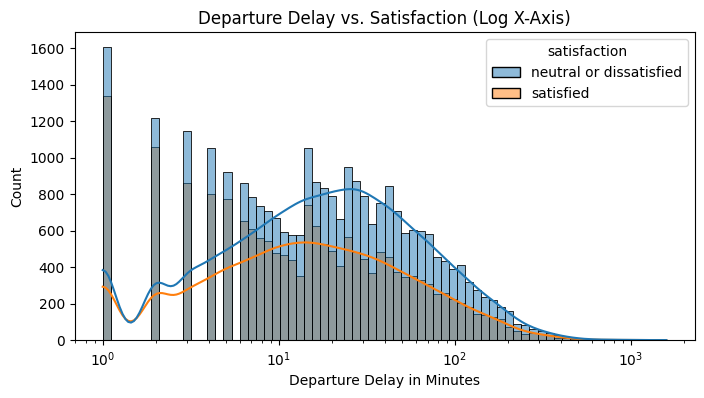

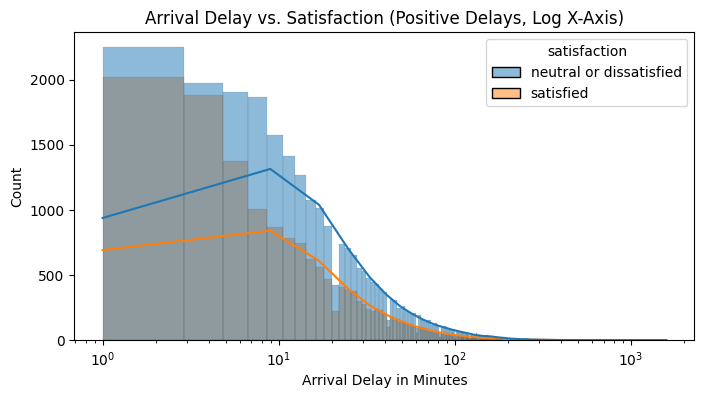

In [83]:
# Operational Metrics vs. Satisfaction
df_positive_delay_departure = df_train[df_train['Departure Delay in Minutes'] > 0]

plt.figure(figsize=(8, 4))
plt.xscale('log')  # Set the x-axis to a logarithmic scale
sns.histplot(data=df_positive_delay_departure, x='Departure Delay in Minutes', hue='satisfaction', kde=True)
plt.title('Departure Delay vs. Satisfaction (Log X-Axis)')
plt.show()

df_positive_delay_arrival = df_train[df_train['Arrival Delay in Minutes'] > 0]

plt.figure(figsize=(8, 4))
# Now plot only the positive delays on a log scale
sns.histplot(data=df_positive_delay_arrival, x='Arrival Delay in Minutes', hue='satisfaction', kde=True)
plt.xscale('log') 
plt.title('Arrival Delay vs. Satisfaction (Positive Delays, Log X-Axis)')
plt.show()



Here it is shown what is expected: the most frequent delay between the 0 to 10 minute range. However, in the case of departuring there are some cases when serious delays are happening frequently, between 10 to 100 minutes - I suppose there are many factors deciding whether a plane can depart or not and it's a different question than the one of landing's. 
What is also clearly present in the graph: minute by minute, the gap between satisfied and unsatisfied travellers grow; following a normalized bell-shape curve where the gap is the biggest where the count of delay is the around the middle of the X-axis.

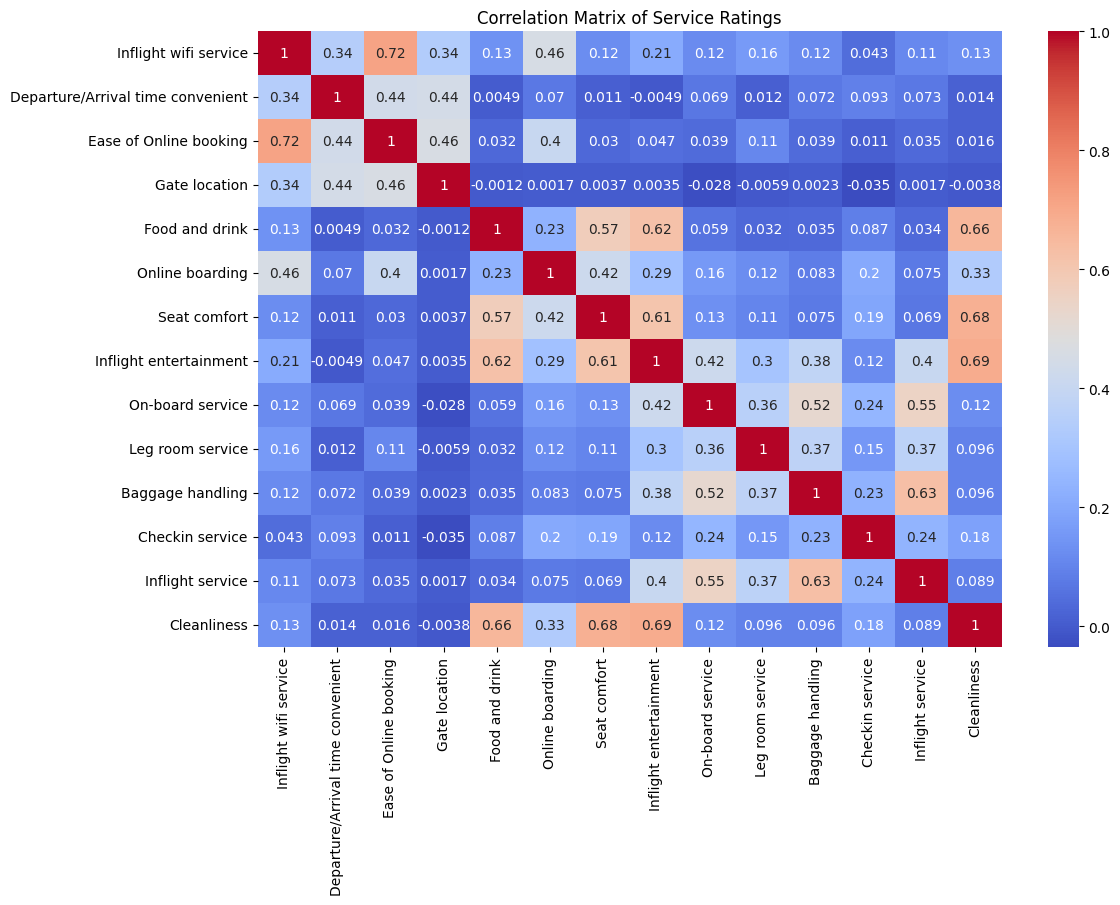

In [84]:
# Service Ratings vs. Satisfaction (Box plots for key ratings)
service_ratings = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 
                   'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 
                   'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 
                   'Checkin service', 'Inflight service', 'Cleanliness']

# Correlation Matrix for Service Ratings
corr_matrix = df_train[service_ratings].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Service Ratings')
plt.show()

There are some clear correlations! Let's keep only those that have higher absolute value than 0.40!

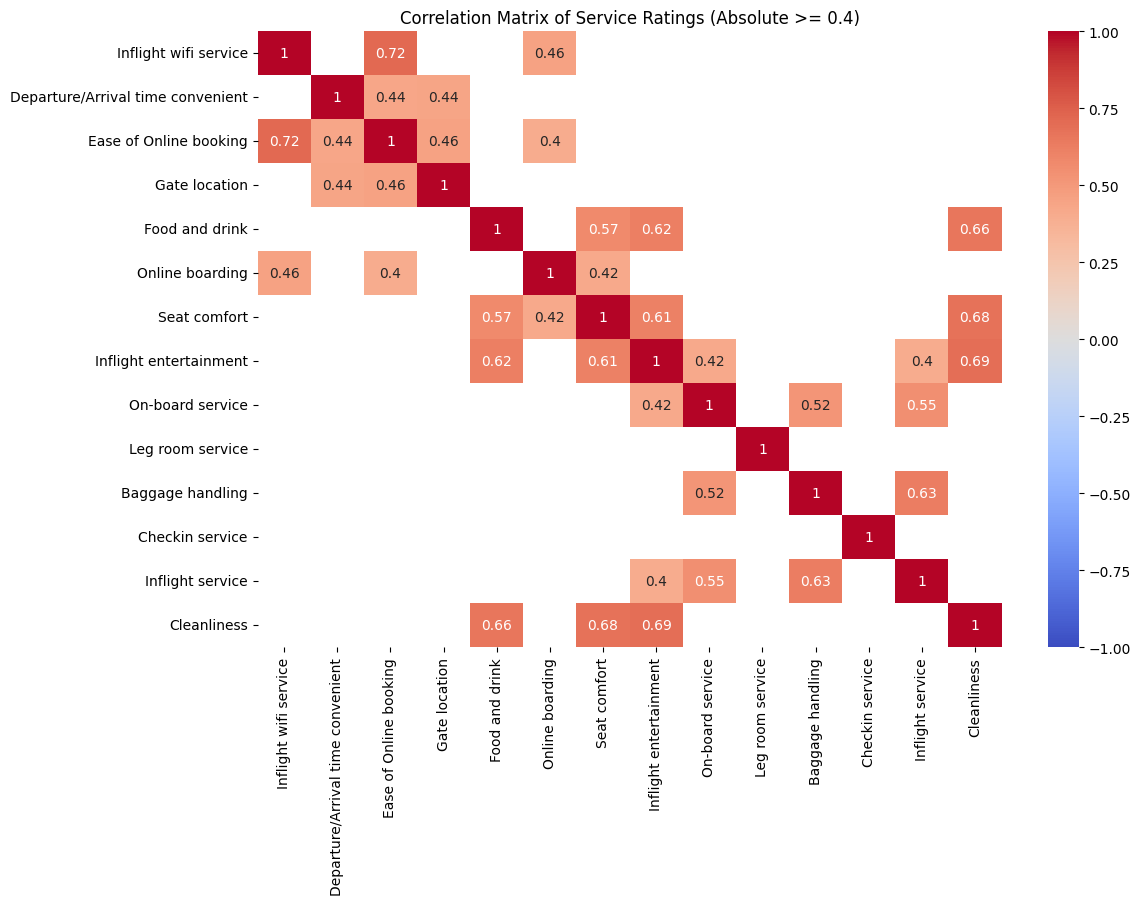

In [85]:
# Create a mask for correlations with absolute value less than 0.4
mask = np.abs(corr_matrix) < 0.4

# Plot the heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Service Ratings (Absolute >= 0.4)')
plt.show()

We can observe that some variables are in many cases in a package, such as online activites regarding the flight. None of the variables hit the |0.85| treshold of multicollinearity, so I plan to keep all of it.

Let's see the decisive factors!

Target Imbalance:
satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64


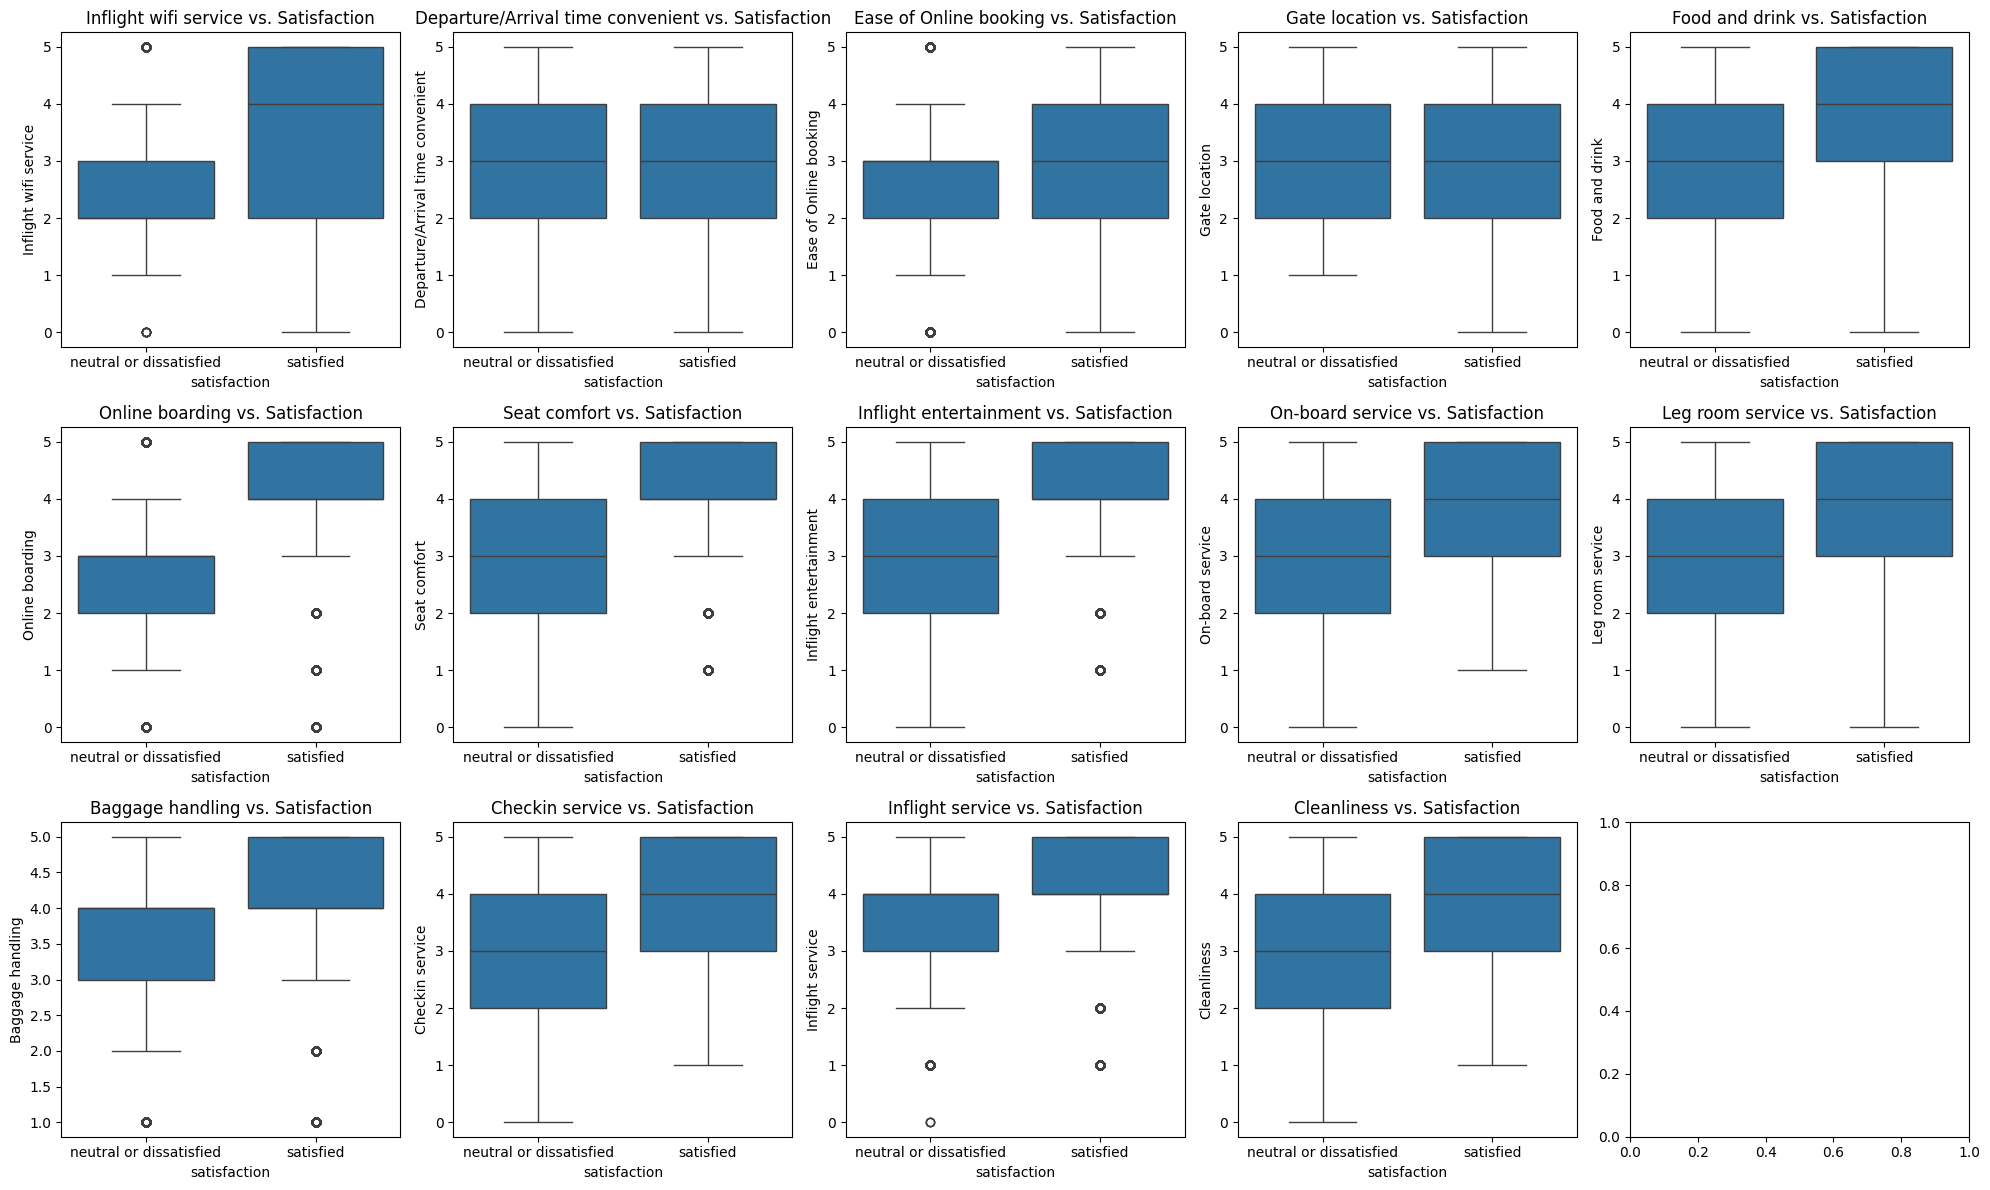

In [86]:
# Target Imbalance Check
print("Target Imbalance:")
print(df_train['satisfaction'].value_counts(normalize=True))



fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()

for i, rating in enumerate(service_ratings):
    sns.boxplot(data=df_train, x='satisfaction', y=rating, ax=axes[i])
    axes[i].set_title(f'{rating} vs. Satisfaction')

plt.tight_layout()
plt.show()

What makes people satisfied indecisevely is the presence or quality of:
- Departure/Arrivel Time Convenient
- Gate location
- Food and Drink
- On-board Service
- Checkin Service

The rest of the variables show more satisfied passengers - seems like these services are quite alright, not as much room to improve.

In [87]:
# Extract target variable from training set
y_train = df_train['satisfaction']
X_train = df_train.drop('satisfaction', axis=1)
# Remove NA
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
# Drop irrelevant columns from X_train
X_train = X_train.drop(['Unnamed: 0', 'id'], axis=1)

# Encode target
y_encoded = y_train.map({'satisfied': 1, 'neutral or dissatisfied': 0})

# Same for test
y_test = df_test['satisfaction']
X_test = df_test.drop('satisfaction', axis=1)
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]
X_test = X_test.drop(['Unnamed: 0', 'id'], axis=1)

# Encode test target
y_test_encoded = y_test.map({'satisfied': 1, 'neutral or dissatisfied': 0})

In [88]:
# Get dummies for categorical columns in X_train
categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)

# Get dummies for test, ensuring same columns
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align test columns to train columns, fill missing with 0
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Impute missing values with train mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

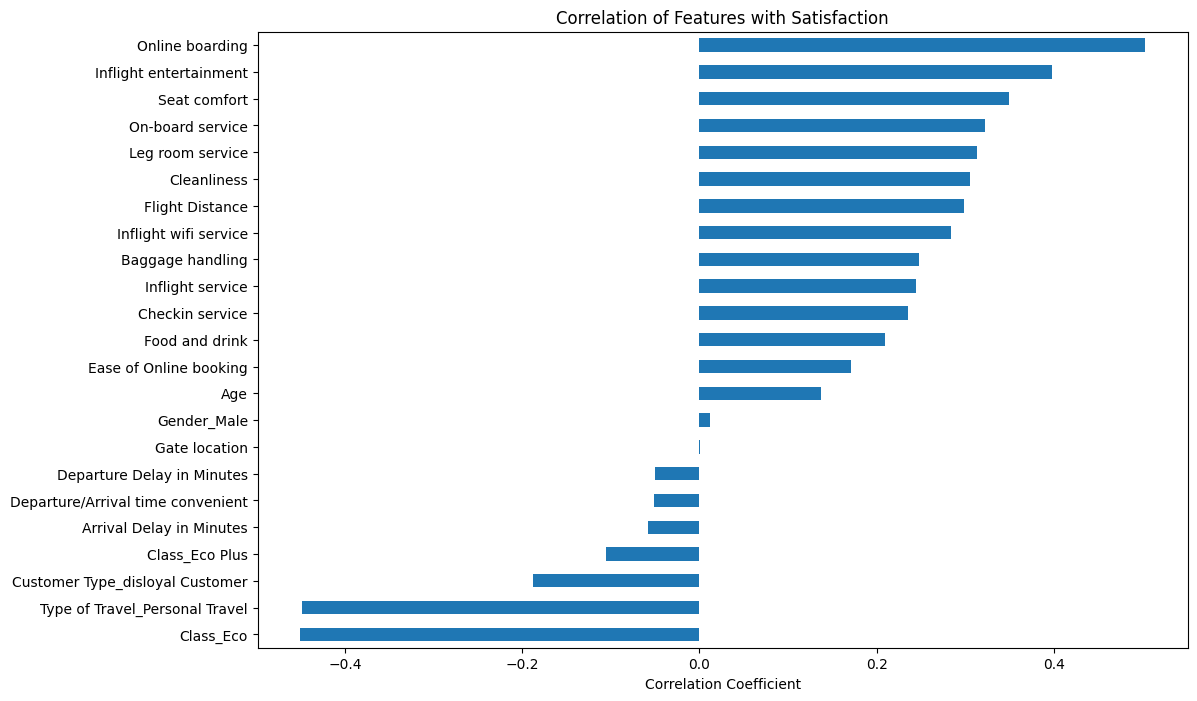

In [89]:
# Include all columns (numerical and dummies)
correlations = X_train.corrwith(y_encoded)

# Plot the correlations as a horizontal bar chart
plt.figure(figsize=(12, 8))
correlations.sort_values().plot(kind='barh')
plt.title('Correlation of Features with Satisfaction')
plt.xlabel('Correlation Coefficient')
plt.show()

Interesting but not surprising insight: The customer and class type have a lot to do with disssatisfaction! Delay is only annoying, but this is hard to avoid.

In [90]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
model.fit(X_train, y_encoded)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Calculate additional metrics
mse = mean_squared_error(y_test_encoded, y_pred)
mae = mean_absolute_error(y_test_encoded, y_pred)
mape = mean_absolute_percentage_error(y_test_encoded, y_pred)

# Initialize dictionary to track model performances
model_performance = {}
# Track performance
model_performance['LogisticRegression'] = {'accuracy': accuracy, 'mse': mse, 'mae': mae, 'mape': mape}

Model Accuracy: 0.8631


In [91]:
from sklearn.metrics import classification_report

# Compute confusion matrix for Logistic Regression
cm = confusion_matrix(y_test_encoded, y_pred)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()

# Calculate precision, recall, f1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"Logistic Regression Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

# Alternatively, use classification_report for a summary
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=['neutral or dissatisfied', 'satisfied']))

Logistic Regression Metrics:
Precision: 0.8493
Recall: 0.8366
F1-Score: 0.8429
Accuracy: 0.8631
MSE: 0.1369
MAE: 0.1369
MAPE: 293421873532384.3125

Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.87      0.88      0.88     14528
              satisfied       0.85      0.84      0.84     11365

               accuracy                           0.86     25893
              macro avg       0.86      0.86      0.86     25893
           weighted avg       0.86      0.86      0.86     25893



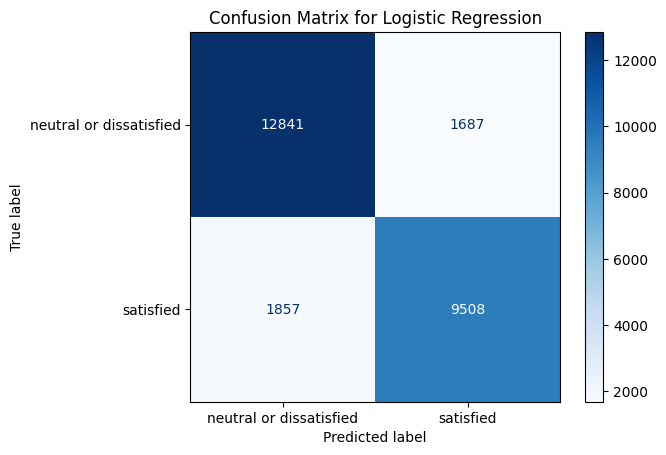

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for Logistic Regression
cm = confusion_matrix(y_test_encoded, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral or dissatisfied', 'satisfied'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

The Logistic Regression model is performing well, but looking in the data it is clear that it's recall needs some improvement.

In [93]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_encoded)

# Predict on test set
lr_y_pred = lr_model.predict(X_test)

# Since it's regression, clip predictions to [0,1] for interpretation as probabilities
lr_y_pred_clipped = np.clip(lr_y_pred, 0, 1)

# Evaluate using regression metrics
lr_mse = mean_squared_error(y_test_encoded, lr_y_pred)
lr_mae = mean_absolute_error(y_test_encoded, lr_y_pred)
lr_mape = mean_absolute_percentage_error(y_test_encoded, lr_y_pred)

# Track performance
model_performance['LinearRegression'] = {'accuracy': None, 'mse': lr_mse, 'mae': lr_mae, 'mape': lr_mape}  # Accuracy not applicable for regression

# Print all performances
print("\nModel Performances:")
for model_name, metrics in model_performance.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: N/A")
    print()


Model Performances:
LogisticRegression:
  accuracy: 0.8631
  mse: 0.1369
  mae: 0.1369
  mape: 293421873532384.3125

LinearRegression:
  accuracy: N/A
  mse: 0.1110
  mae: 0.2490
  mape: 591046915224894.5000



In [94]:
# Code to calculate the score of a dummy classifier
pos_frac = np.sum(y_encoded==1)/len(y_encoded)  # share of the positive class, which typically represents the minority
print('A dummy classifier that always predicts the majority class, achieves classification accuracy equal to {:.2f}%'.format(100*(1-pos_frac)))

A dummy classifier that always predicts the majority class, achieves classification accuracy equal to 56.66%


That looks fabulous! The model can predict a customer's satisfaction with an accuracy over 80%! As the target is almost equally distributed, the model clearly performs amazingly.

Either ways, let's try an Ensemble model as well!

In [95]:
# Random Forest Ensemble Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_encoded)

# Predict on test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test_encoded, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Calculate additional metrics
rf_mse = mean_squared_error(y_test_encoded, rf_y_pred)
rf_mae = mean_absolute_error(y_test_encoded, rf_y_pred)
rf_mape = mean_absolute_percentage_error(y_test_encoded, rf_y_pred)

# Track performance
model_performance['RandomForest'] = {'accuracy': rf_accuracy, 'mse': rf_mse, 'mae': rf_mae, 'mape': rf_mape}

# Print all performances
print("\nModel Performances:")
for model_name, metrics in model_performance.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

Random Forest Accuracy: 0.9625

Model Performances:
LogisticRegression:
  accuracy: 0.8631
  mse: 0.1369
  mae: 0.1369
  mape: 293421873532384.3125

LinearRegression:


TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
from sklearn.metrics import classification_report

# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test_encoded, rf_y_pred)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm_rf.ravel()

# Calculate precision, recall, f1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"Random Forest Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"MSE: {rf_mse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"MAPE: {rf_mape:.4f}")

# Alternatively, use classification_report for a summary
print("\nClassification Report:")
print(classification_report(y_test_encoded, rf_y_pred, target_names=['neutral or dissatisfied', 'satisfied']))

Random Forest Metrics:
Precision: 0.9720
Recall: 0.9417
F1-Score: 0.9566
Accuracy: 0.9625
MSE: 0.0375
MAE: 0.0375
MAPE: 53570798487240.3047

Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14528
              satisfied       0.97      0.94      0.96     11365

               accuracy                           0.96     25893
              macro avg       0.96      0.96      0.96     25893
           weighted avg       0.96      0.96      0.96     25893



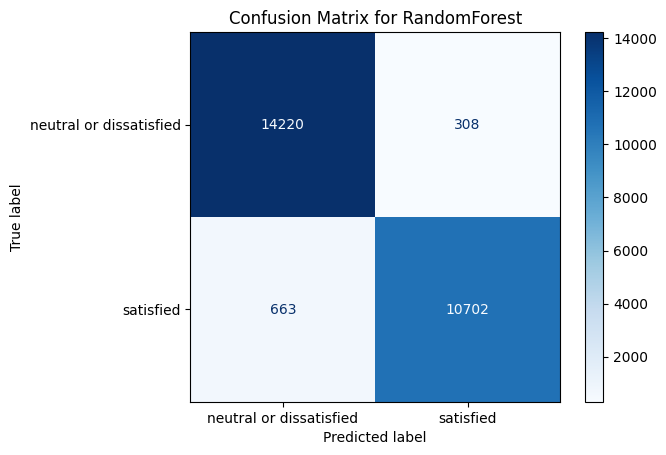

In [ ]:
cm = confusion_matrix(y_test_encoded, rf_y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral or dissatisfied', 'satisfied'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for RandomForest')
plt.show()

Not very surprisingly, RandomForest outperforms the logistic regression. It is performing better in precision and recall. Let's check different models as well, but I don't expect big differences.

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_encoded)

# Predict on test set
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate accuracy
xgb_accuracy = accuracy_score(y_test_encoded, xgb_y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Calculate additional metrics
xgb_mse = mean_squared_error(y_test_encoded, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test_encoded, xgb_y_pred)
xgb_mape = mean_absolute_percentage_error(y_test_encoded, xgb_y_pred)

# Track performance
model_performance['XGBoost'] = {'accuracy': xgb_accuracy, 'mse': xgb_mse, 'mae': xgb_mae, 'mape': xgb_mape}

# Print all performances
for model_name, metrics in model_performance.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

XGBoost Accuracy: 0.9627
LogisticRegression:
  accuracy: 0.8631
  mse: 0.1369
  mae: 0.1369
  mape: 293421873532384.3125

RandomForest:
  accuracy: 0.9625
  mse: 0.0375
  mae: 0.0375
  mape: 53570798487240.3047

XGBoost:
  accuracy: 0.9627
  mse: 0.0373
  mae: 0.0373
  mape: 56875490601712.9219



XGBoost Metrics:
Precision: 0.9704
Recall: 0.9437
F1-Score: 0.9569
Accuracy: 0.9627
MSE: 0.0373
MAE: 0.0373
MAPE: 56875490601712.9219

Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14528
              satisfied       0.97      0.94      0.96     11365

               accuracy                           0.96     25893
              macro avg       0.96      0.96      0.96     25893
           weighted avg       0.96      0.96      0.96     25893



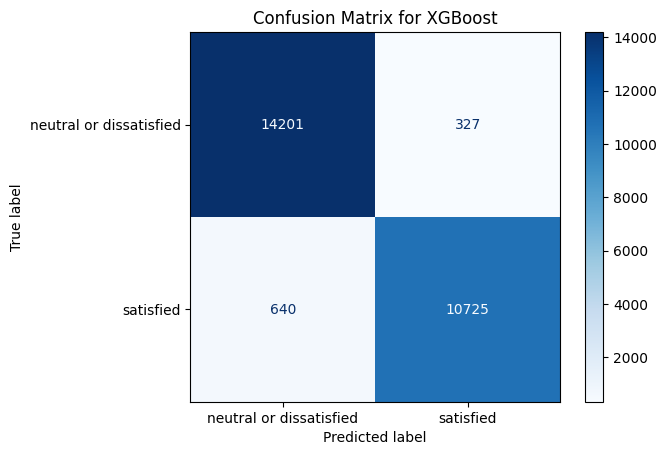

In [ ]:
from sklearn.metrics import classification_report

# Compute confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_encoded, xgb_y_pred)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm_xgb.ravel()

# Calculate precision, recall, f1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"XGBoost Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"MSE: {xgb_mse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"MAPE: {xgb_mape:.4f}")

# Alternatively, use classification_report for a summary
print("\nClassification Report:")
print(classification_report(y_test_encoded, xgb_y_pred, target_names=['neutral or dissatisfied', 'satisfied']))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['neutral or dissatisfied', 'satisfied'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.show()

XGBoost is really close to RandomForest, but performed a little bit better - not significantly. However, XGBoost finished under the half of the time it took for RandomForest.

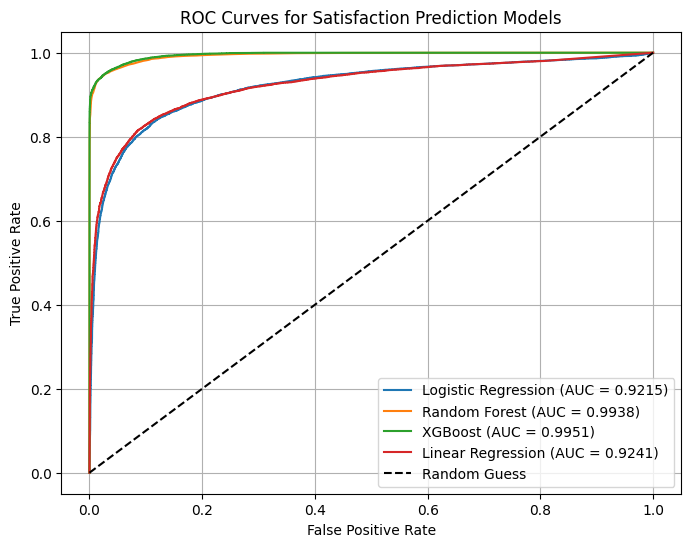

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for Logistic Regression
y_pred_proba_lr = model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, y_pred_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Get predicted probabilities for Random Forest
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_encoded, rf_y_pred_proba)
auc_rf = auc(fpr_rf, tpr_rf)

# Get predicted probabilities for XGBoost
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_encoded, xgb_y_pred_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Get predicted probabilities for Linear Regression (using clipped predictions)
fpr_lr_reg, tpr_lr_reg, _ = roc_curve(y_test_encoded, lr_y_pred_clipped)
auc_lr_reg = auc(fpr_lr_reg, tpr_lr_reg)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_lr_reg, tpr_lr_reg, label=f'Linear Regression (AUC = {auc_lr_reg:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Satisfaction Prediction Models')
plt.legend()
plt.grid(True)
plt.show()

We are looking for a perfect AUC value of 1 - or at least the model that gets the closest. Surprisingly, Linear and Logistic Regression performs equally - well, in this case - poor, compared to the Ensemble models, those having 0.99 AUC. Let's stick then with the XGBOOST!

The following code runs superlong and does not tune treally the performance, so I decided to comment it out and stick with the original model.

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid for XGBoost tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Initialize XGBoost model
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Perform grid search
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_encoded)

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score:", grid_search.best_score_)

# # Retrain with best parameters
# best_xgb_model = grid_search.best_estimator_
# best_xgb_model.fit(X_train, y_encoded)

# # Predict on test set with tuned model
# tuned_y_pred = best_xgb_model.predict(X_test)
# tuned_accuracy = accuracy_score(y_test_encoded, tuned_y_pred)
# print(f"Tuned XGBoost Accuracy: {tuned_accuracy:.4f}")

# # Update model_performance
# model_performance['TunedXGBoost'] = {'accuracy': tuned_accuracy, 'mse': mean_squared_error(y_test_encoded, tuned_y_pred), 'mae': mean_absolute_error(y_test_encoded, tuned_y_pred), 'mape': mean_absolute_percentage_error(y_test_encoded, tuned_y_pred)}

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

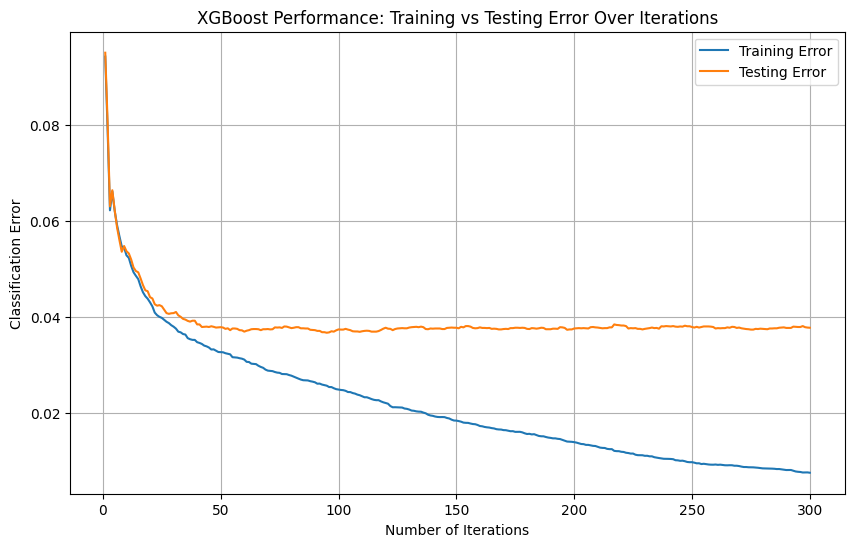

In [98]:
# Retrain XGBoost with eval_set to capture performance over iterations
eval_set = [(X_train, y_encoded), (X_test, y_test_encoded)]
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42, n_estimators=300)
xgb_model.fit(X_train, y_encoded, eval_set=eval_set, verbose=False)

# Get evaluation results
results = xgb_model.evals_result()

# Plot training and testing error over iterations
iterations = len(results['validation_0']['error'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, iterations + 1), results['validation_0']['error'], label='Training Error')
plt.plot(range(1, iterations + 1), results['validation_1']['error'], label='Testing Error')
plt.xlabel('Number of Iterations')
plt.ylabel('Classification Error')
plt.title('XGBoost Performance: Training vs Testing Error Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

As it is displayed, after 50 iterations, the testing error won't reduce, so that's what we are aiming for to save on computing cost.

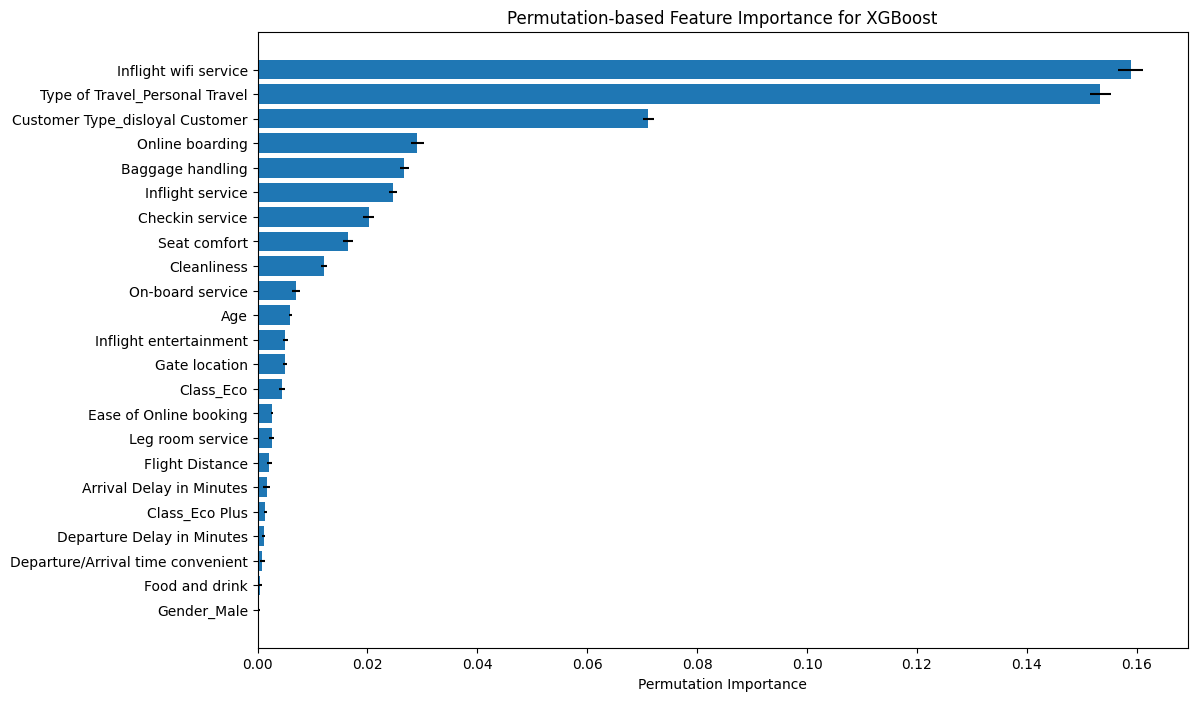

In [99]:
from sklearn.inspection import permutation_importance

# Compute permutation importance for XGBoost model
perm_importance = permutation_importance(xgb_model, X_test, y_test_encoded, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
feature_names = X_test.columns
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

# Sort by importance
perm_df = perm_df.sort_values(by='importance_mean', ascending=False)

# Plot the permutation importance
plt.figure(figsize=(12, 8))
plt.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation-based Feature Importance for XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

Another interesting result! Seems like inflight wifi has to do a lot with customer satisfaction, just as the type of the passenger!

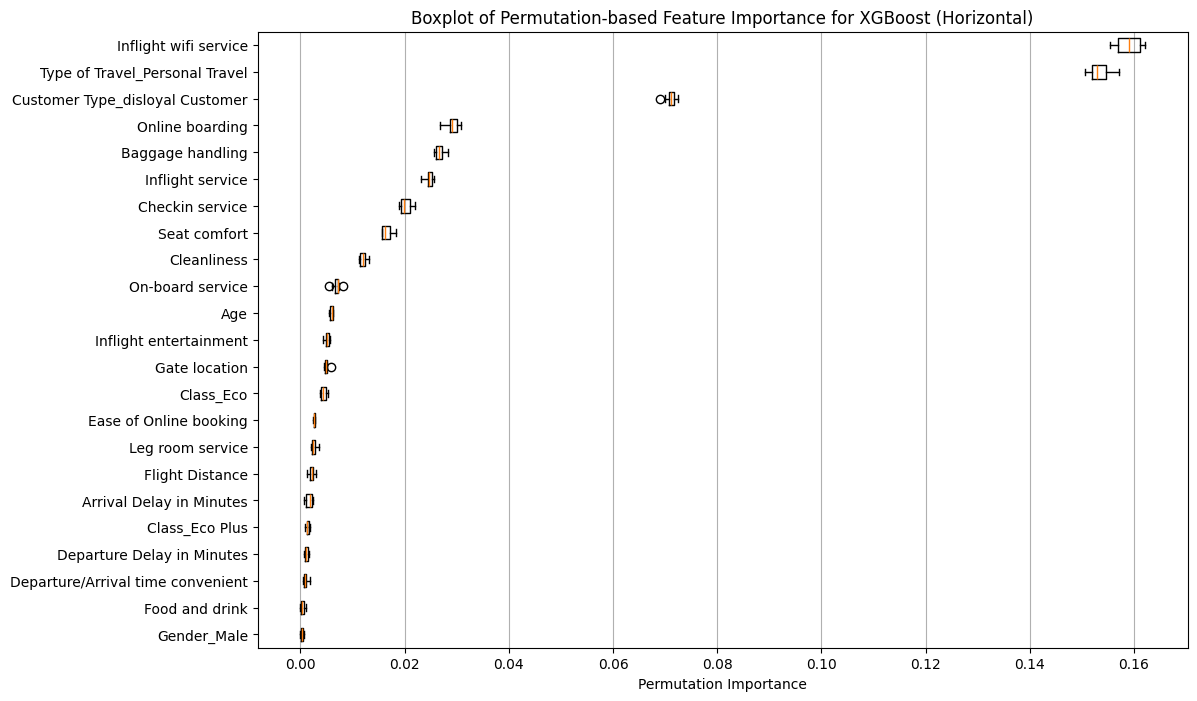

In [102]:
import matplotlib.pyplot as plt

# Extract the individual importances for each feature
importances = perm_importance.importances  # Shape: (n_features, n_repeats)
# sort importances by mean importance
sorted_idx = np.argsort(perm_importance.importances_mean)
importances = importances[sorted_idx]
feature_names = feature_names[sorted_idx]

# Create a horizontal boxplot for permutation importances
plt.figure(figsize=(12, 8))
plt.boxplot(importances.T, vert=False, labels=feature_names)
plt.xlabel('Permutation Importance')
plt.title('Boxplot of Permutation-based Feature Importance for XGBoost (Horizontal)')
plt.grid(True, axis='x')
plt.show()

Corrupting each feature, seems like truly the passenger type and wifi service matters the most... and it makes sense! A businessman wants to work during the flight, so the person will be extremely satisfied if this is possible due to wifi. That's not what they all need, but makes up for a lot! It explains the needs of business persons but it also highlights the problem of those who are on a personal trip. They still need something!

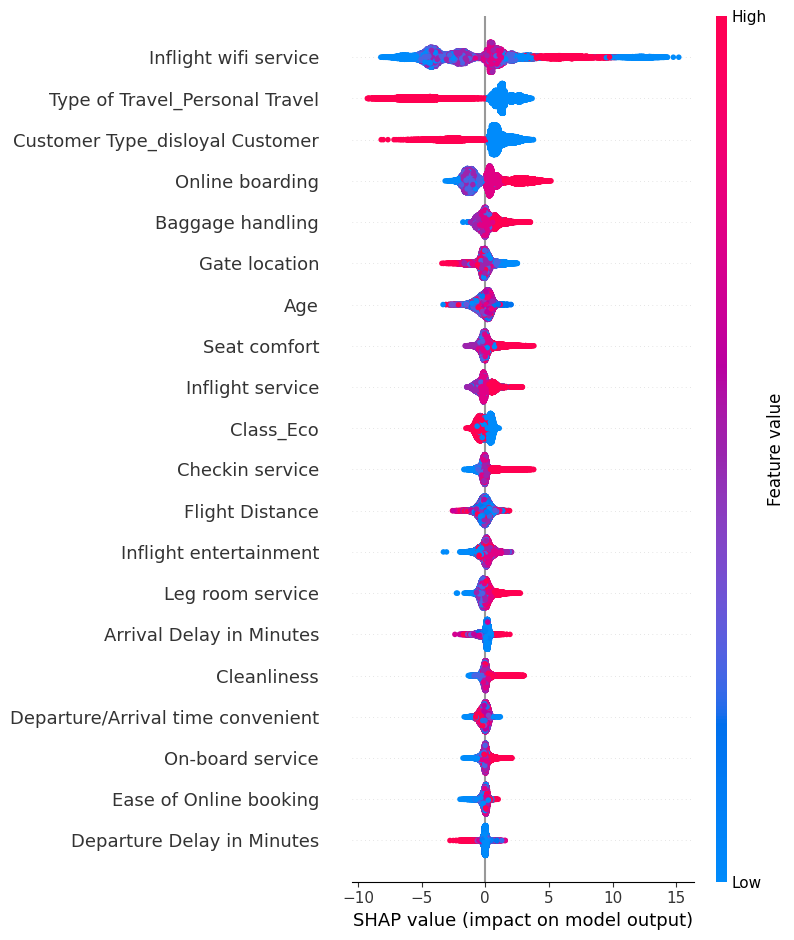

In [ ]:
import shap

# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
# **** Note that this computation is costly and may take a while to run ****


In [112]:
shap_values = explainer(X_test)
print("Shape of result: {}".format(np.shape(shap_values)))  # some output to signal when done

Shape of result: (25893, 23)


In [111]:
X_test.shape

(25893, 23)

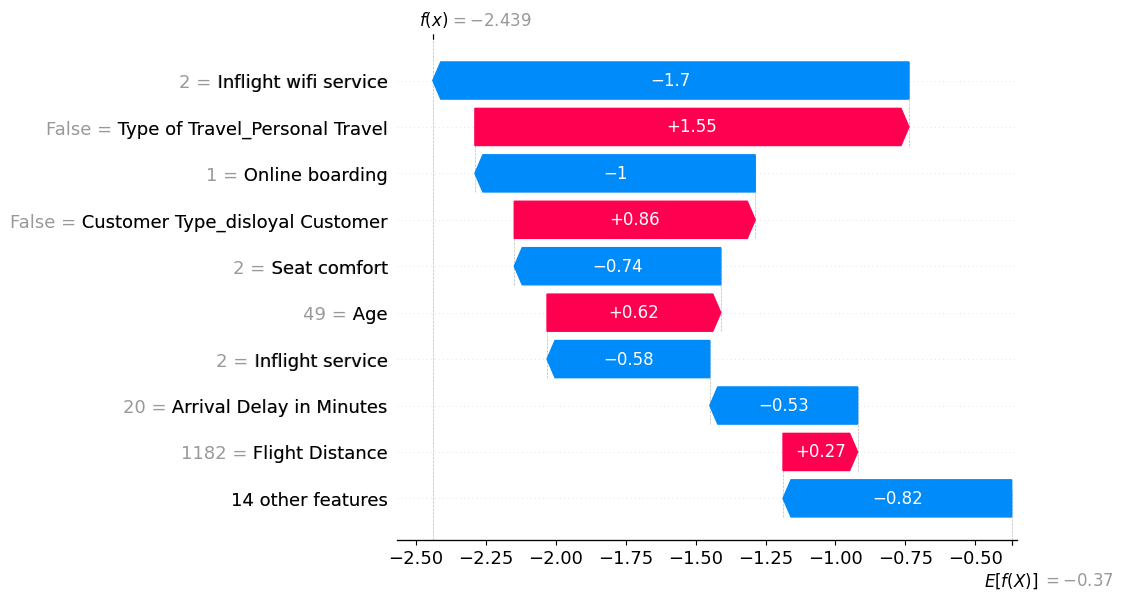

In [ ]:
test_point = 4
# shap.initjs()
# shap.plots.waterfall(shap_values[test_point])

In [ ]:
# shap.initjs()
# shap.plots.force(shap_values[test_point])

In [119]:

shap.initjs()
shap.plots.force(shap_values[:100])  # first 100 data points

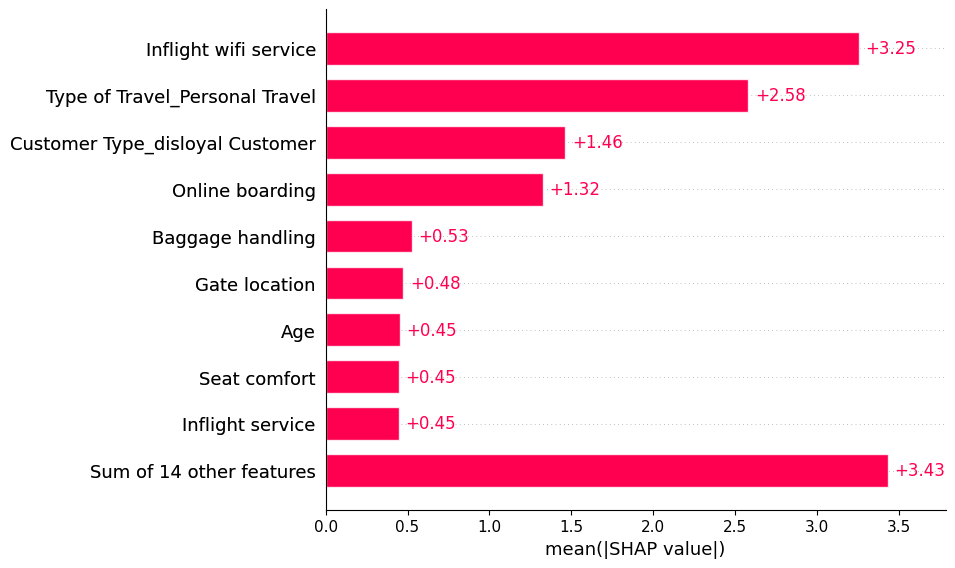

In [120]:
# SHAP-based feature importance analysis simplified
shap.initjs()
shap.plots.bar(shap_values)

As mentioned, the presence of Wifi is a key ingredient for satisfaction... but once again, for one type of travellers.

Type of Travel_Personal Travel: Being a Personal Traveler (high feature value for this binary factor, thus red) is the single strongest driver of dissatisfaction.

Customer Type_disloyal Customer: Being a disloyal customer (red dots) also strongly pushes the prediction toward dissatisfaction.

Arrival Delay in Minutes & Departure Delay in Minutes: These features have a very small SHAP impact, clustering near zero. This confirms the Permutation Importance result: while common sense says delays cause dissatisfaction, the model finds that simply knowing a passenger's travel type and class is far more predictive of their final satisfaction status than the exact delay duration.

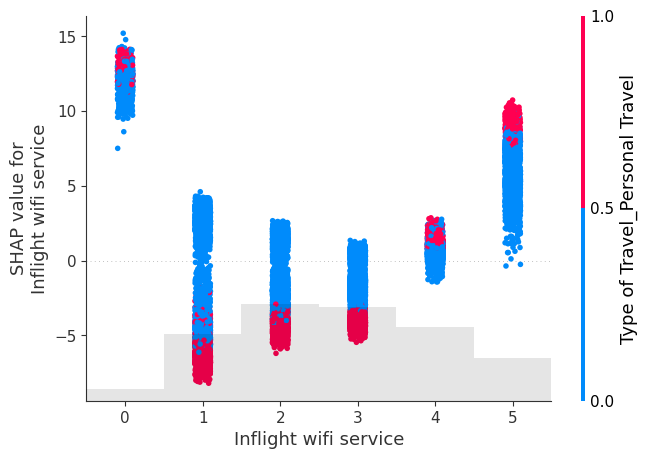

In [ ]:
# shap.initjs()
# shap.plots.scatter(shap_values[:, "Inflight wifi service"], color=shap_values)